In [134]:
!pip install torch_geometric

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score

import torch
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [136]:
df = pd.read_csv('/content/creditcard.csv')
df_eda = df.copy()
df.shape

(284807, 31)

In [137]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [138]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [140]:
df.describe().style.background_gradient()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,88.349619,0.001727
std,47488.145955,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.088850,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109,0.041527
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54201.500000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.498850,-0.456299,-0.211721,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,5.600000,0.000000
50%,84692.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.000000,0.000000
75%,139320.500000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.493150,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,77.165000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


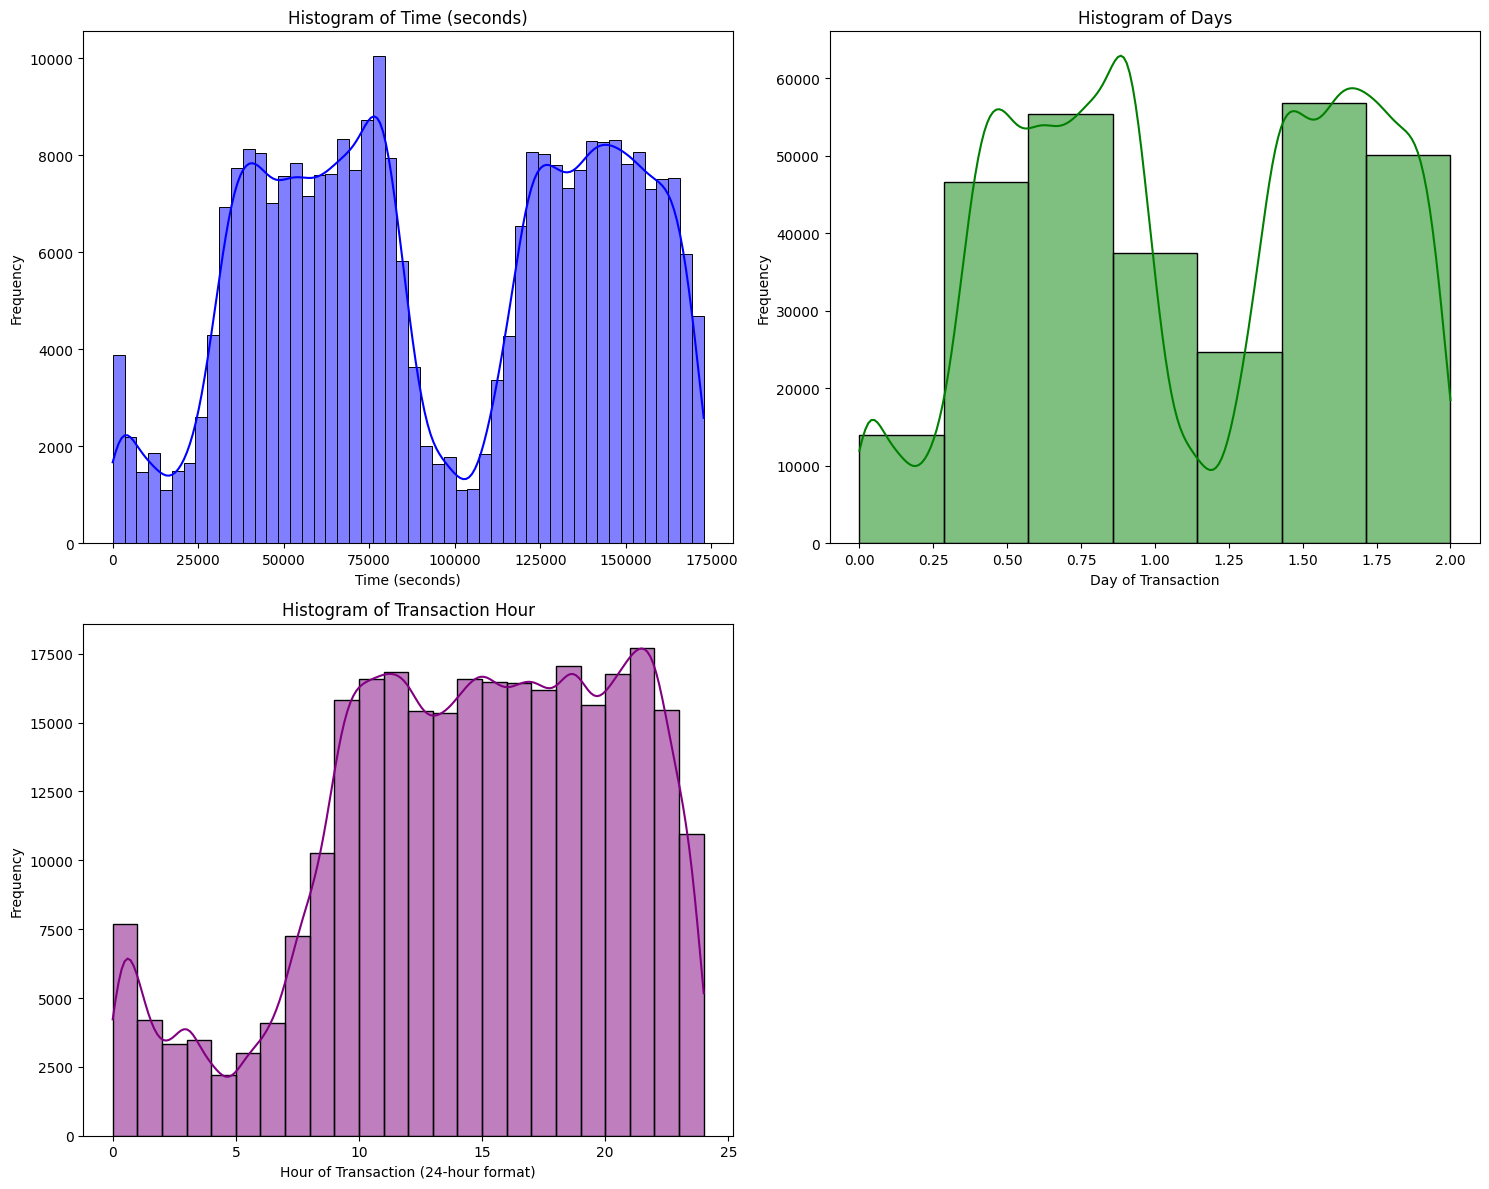

In [141]:
# Convert 'Time' column to seconds
df_eda['Time_Hours'] = df_eda['Time'] / 3600  # Convert seconds to hours
df_eda['Time_Days'] = df_eda['Time'] / (3600 * 24)  # Convert seconds to days

# Extract hour of the day (assuming start at midnight)
df_eda['Transaction_Hour'] = df_eda['Time_Hours'] % 24

# Plot histograms
plt.figure(figsize=(15, 12))

# 1. Histogram of 'Time'
plt.subplot(2, 2, 1)
sns.histplot(df_eda['Time'], bins=50, kde=True, color='blue')
plt.title('Histogram of Time (seconds)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

# 2. Histogram of 'Days'
plt.subplot(2, 2, 2)
sns.histplot(df_eda['Time_Days'], bins=7, kde=True, color='green')
plt.title('Histogram of Days')
plt.xlabel('Day of Transaction')
plt.ylabel('Frequency')

# 3. Histogram of 'Transaction_Hour'
plt.subplot(2, 2, 3)
sns.histplot(df_eda['Transaction_Hour'], bins=24, kde=True, color='purple')
plt.title('Histogram of Transaction Hour')
plt.xlabel('Hour of Transaction (24-hour format)')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

<ipython-input-142-2848d751fc7c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df_eda, palette='viridis')


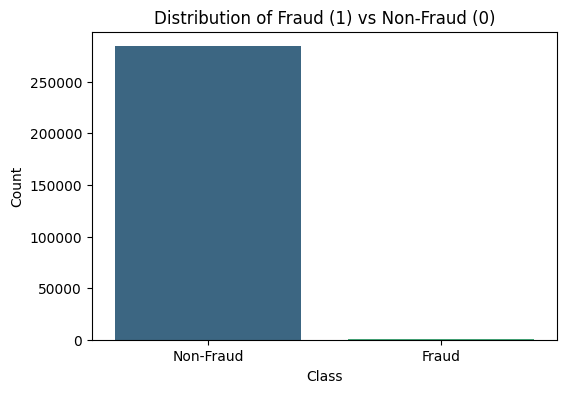

Number of Fraudulent Transactions: 0.17%


In [142]:
# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df_eda, palette='viridis')
plt.title('Distribution of Fraud (1) vs Non-Fraud (0)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

# Percentage of Fraudulent Transactions
fraud_percentage = (df_eda['Class'].value_counts()[1] / len(df_eda)) * 100
print(f"Number of Fraudulent Transactions: {fraud_percentage:.2f}%")

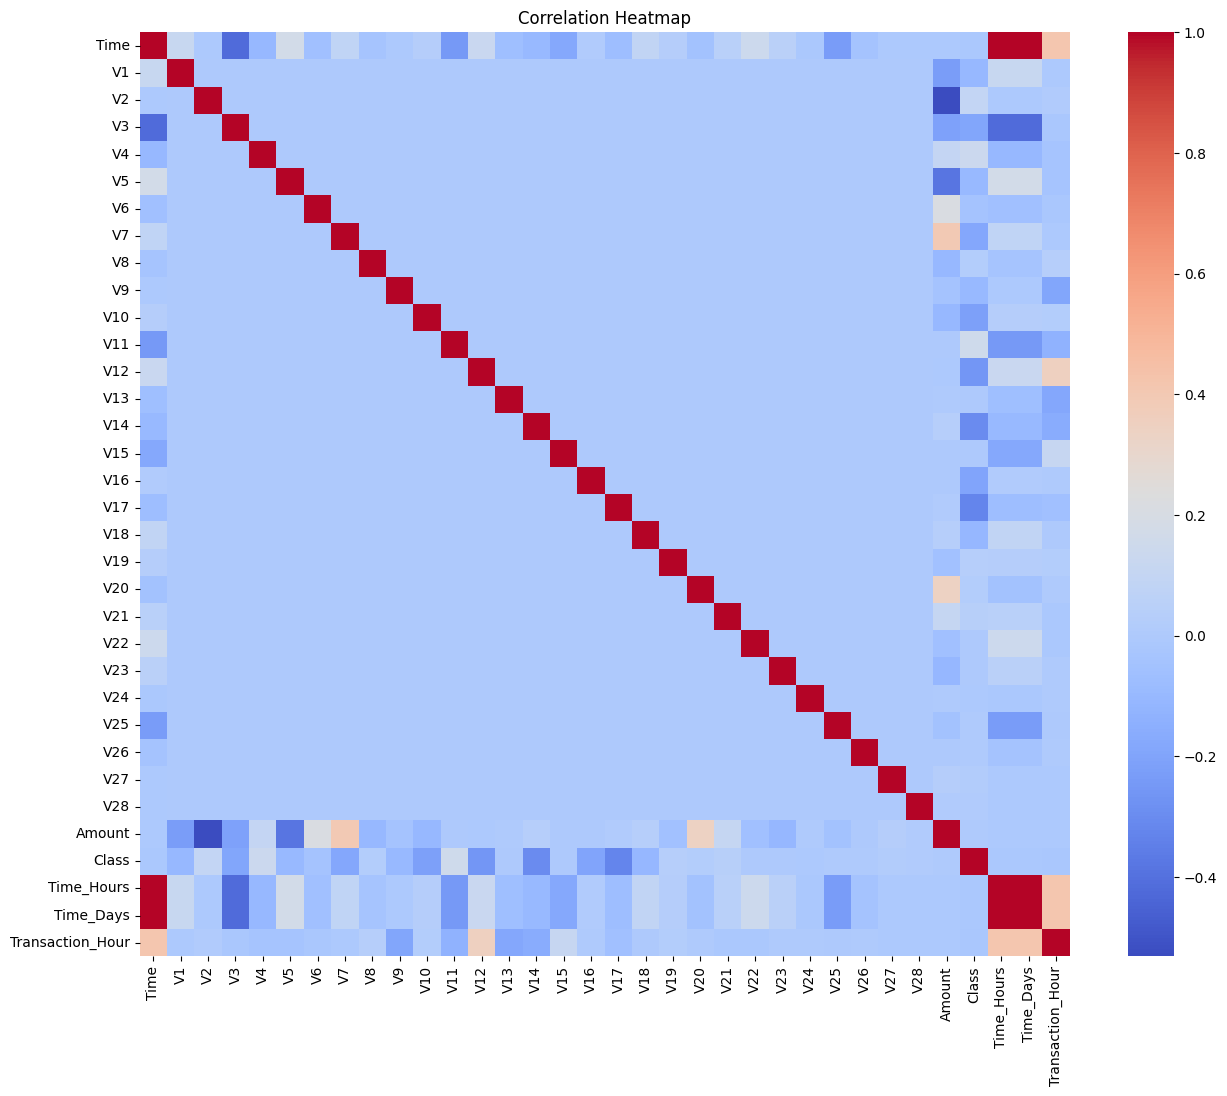

In [143]:
# Correlation heatmap
plt.figure(figsize=(15, 12))
corr = df_eda.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

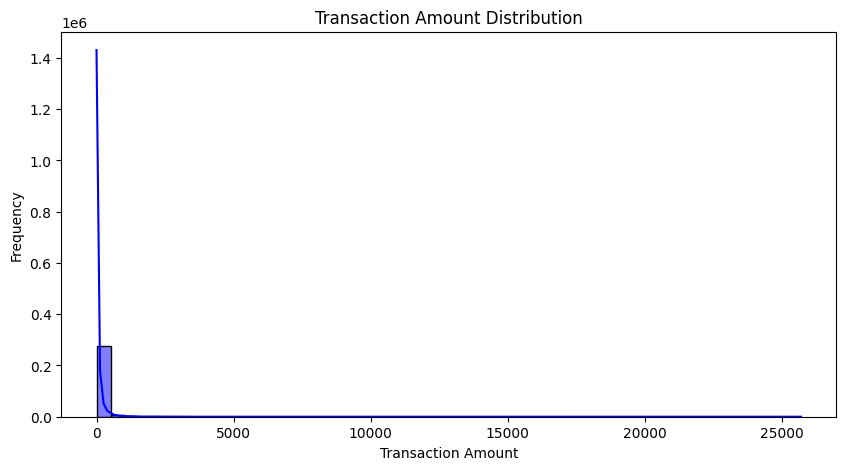

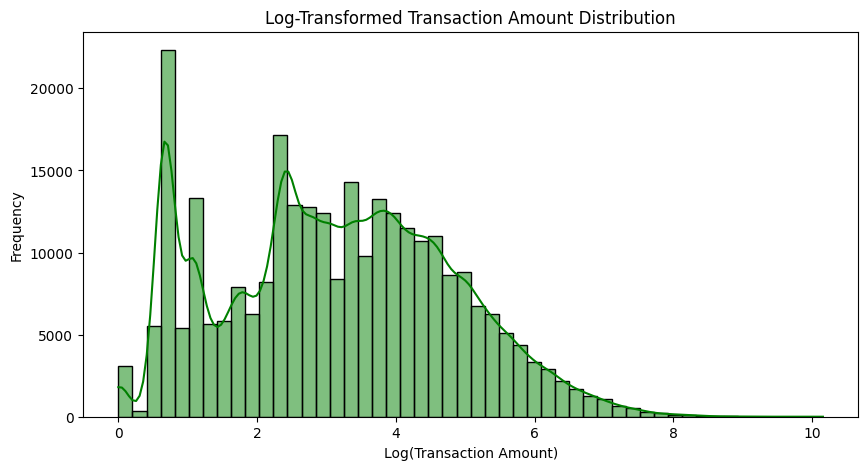

In [144]:
# Distribution of Transaction Amounts
plt.figure(figsize=(10, 5))
sns.histplot(df_eda['Amount'], bins=50, kde=True, color='blue')
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# Log-transform Amount
df_eda['Log_Amount'] = np.log1p(df_eda['Amount'])

plt.figure(figsize=(10, 5))
sns.histplot(df_eda['Log_Amount'], bins=50, kde=True, color='green')
plt.title('Log-Transformed Transaction Amount Distribution')
plt.xlabel('Log(Transaction Amount)')
plt.ylabel('Frequency')
plt.show()

<ipython-input-145-e13dcb9045e0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Amount', data=df_eda, palette='coolwarm')


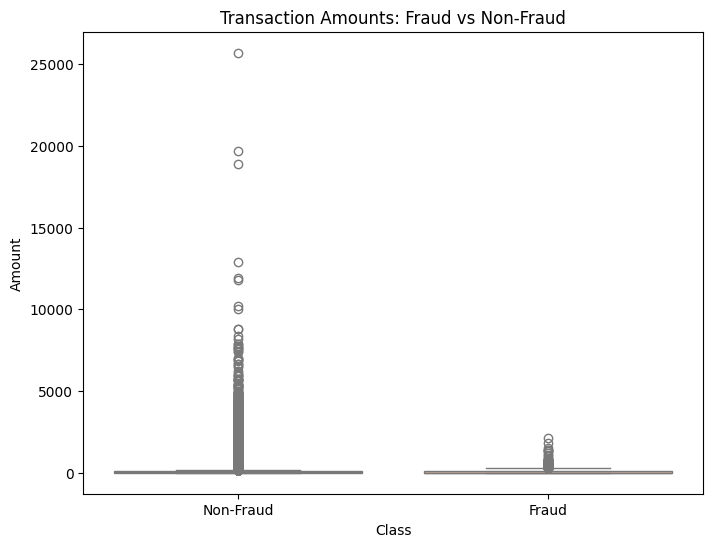

In [145]:
# Boxplot for Fraud vs Non-Fraud Amounts
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=df_eda, palette='coolwarm')
plt.title('Transaction Amounts: Fraud vs Non-Fraud')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

In [146]:
def plot_kde_for_feature(feature):
    # Plot the KDE of the selected feature
    plt.figure(figsize=(10, 6))

    # Plot for Non-Fraud (Class == 0)
    sns.kdeplot(df_eda.loc[df_eda['Class'] == 0, feature], label='Non-Fraud', fill=True, color='blue')

    # Plot for Fraud (Class == 1)
    sns.kdeplot(df_eda.loc[df_eda['Class'] == 1, feature], label='Fraud', fill=True, color='red')

    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()

# Create a dropdown for selecting the feature (V1 to V28)
feature_dropdown = widgets.Dropdown(
    options=[f'V{i}' for i in range(1, 29)],  # Features V1 to V28
    value='V1',  # Default value
    description='Feature:',
    disabled=False
)

# Use the interact function to update the plot based on the selected feature
interact(plot_kde_for_feature, feature=feature_dropdown)

interactive(children=(Dropdown(description='Feature:', options=('V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8'…

<function __main__.plot_kde_for_feature(feature)>

In [147]:
'''# Scale PCA features
X = df.drop(['Class', 'Time', 'Amount'], axis=1)
X_scaled = StandardScaler().fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot t-SNE results
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['Class'], palette='viridis', alpha=0.7)
plt.title('t-SNE Clustering of Transactions')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.show()'''

"# Scale PCA features\nX = df.drop(['Class', 'Time', 'Amount'], axis=1)\nX_scaled = StandardScaler().fit_transform(X)\n\n# Apply t-SNE\ntsne = TSNE(n_components=2, random_state=42)\nX_tsne = tsne.fit_transform(X_scaled)\n\n# Plot t-SNE results\nplt.figure(figsize=(10, 7))\nsns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['Class'], palette='viridis', alpha=0.7)\nplt.title('t-SNE Clustering of Transactions')\nplt.xlabel('t-SNE 1')\nplt.ylabel('t-SNE 2')\nplt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])\nplt.show()"

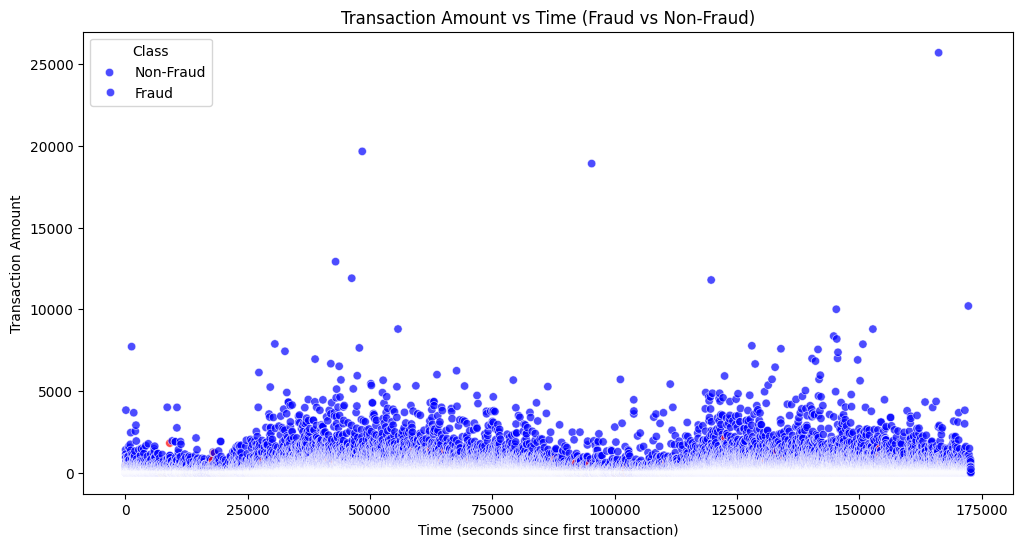

In [148]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_eda, x='Time', y='Amount', hue='Class', palette={0: 'blue', 1: 'red'}, alpha=0.7)
plt.title('Transaction Amount vs Time (Fraud vs Non-Fraud)')
plt.xlabel('Time (seconds since first transaction)')
plt.ylabel('Transaction Amount')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.show()

<ipython-input-149-a840a73f5440>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_percentage = df_eda.groupby('Amount_Bin')['Class'].mean() * 100
<ipython-input-149-a840a73f5440>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_percentage.index, y=fraud_percentage.values, palette="coolwarm")


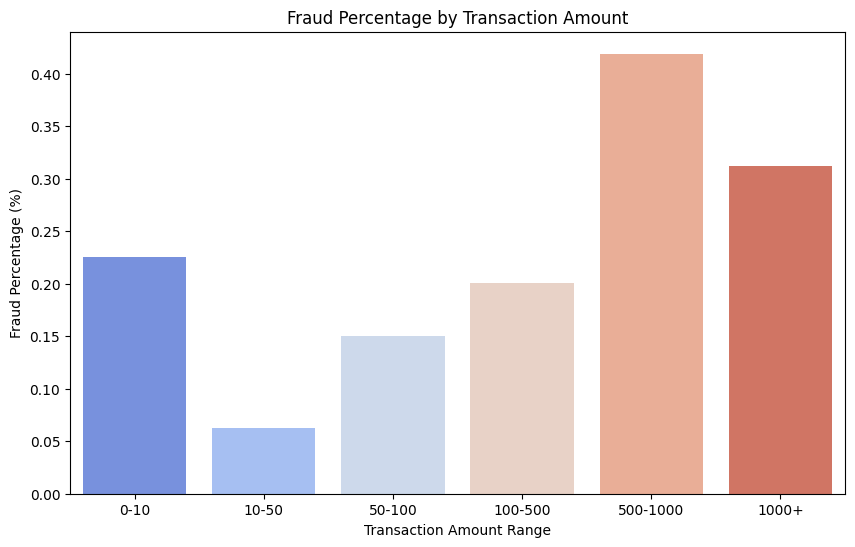

In [149]:
# Create transaction amount bins
df_eda['Amount_Bin'] = pd.cut(df_eda['Amount'], bins=[0, 10, 50, 100, 500, 1000, 5000],
                          labels=['0-10', '10-50', '50-100', '100-500', '500-1000', '1000+'])

# Calculate fraud percentage per bin
fraud_percentage = df_eda.groupby('Amount_Bin')['Class'].mean() * 100

# Plot fraud percentage by amount bin
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_percentage.index, y=fraud_percentage.values, palette="coolwarm")
plt.title('Fraud Percentage by Transaction Amount')
plt.xlabel('Transaction Amount Range')
plt.ylabel('Fraud Percentage (%)')
plt.show()

In [150]:
def plot_fraud_probability(feature):
    # Bin the selected feature
    df_eda['Binned_Feature'] = pd.cut(df_eda[feature], bins=10)

    # Calculate fraud probability by bin
    fraud_prob = df_eda.groupby('Binned_Feature')['Class'].mean()

    # Plot fraud probability
    plt.figure(figsize=(10, 6))
    sns.barplot(x=fraud_prob.index.astype(str), y=fraud_prob.values, palette='viridis')
    plt.title(f'Fraud Probability by {feature} Feature Bin')
    plt.xlabel(f'{feature} Feature Range')
    plt.ylabel('Fraud Probability')
    plt.xticks(rotation=45)
    plt.show()

# Create a dropdown for feature selection (V1 to V28)
feature_dropdown = widgets.Dropdown(
    options=[f'V{i}' for i in range(1, 29)],
    value='V1',
    description='Feature:',
    disabled=False)

# Interactive plot based on selected feature
interact(plot_fraud_probability, feature=feature_dropdown)


interactive(children=(Dropdown(description='Feature:', options=('V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8'…

<function __main__.plot_fraud_probability(feature)>

In [151]:
# Function to calculate fraud probability for each feature
def find_fraud_probability_features():
    high_fraud_features = []  # List to store features with >80% fraud probability
    low_fraud_features = []   # List to store features with <15% fraud probability

    for feature in [f'V{i}' for i in range(1, 29)]:  # Loop through features V1 to V28
        # Bin the feature into 10 bins
        df_eda['Binned_Feature'] = pd.cut(df_eda[feature], bins=10)

        # Calculate fraud probability by bin, set observed=False to avoid future warning
        fraud_prob = df_eda.groupby('Binned_Feature', observed=False)['Class'].mean()

        # Check if any fraud probability exceeds 80% or is less than 15%
        if (fraud_prob > 0.8).any():
            high_fraud_features.append(feature)
        elif (fraud_prob < 0.10).any():
            low_fraud_features.append(feature)

    return high_fraud_features, low_fraud_features

# Get features with fraud probability > 80% and < 15%
high_fraud_features, low_fraud_features = find_fraud_probability_features()

# Print the results
print("Features with fraud probability greater than 80%:")
print(high_fraud_features)
print("\nFeatures with fraud probability less than 15%:")
print(low_fraud_features)

Features with fraud probability greater than 80%:
['V2', 'V3', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']

Features with fraud probability less than 15%:
['V1', 'V4', 'V5', 'V6', 'V8', 'V13', 'V15', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


<ipython-input-152-ca8eace7a59e>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=outliers, palette='viridis')


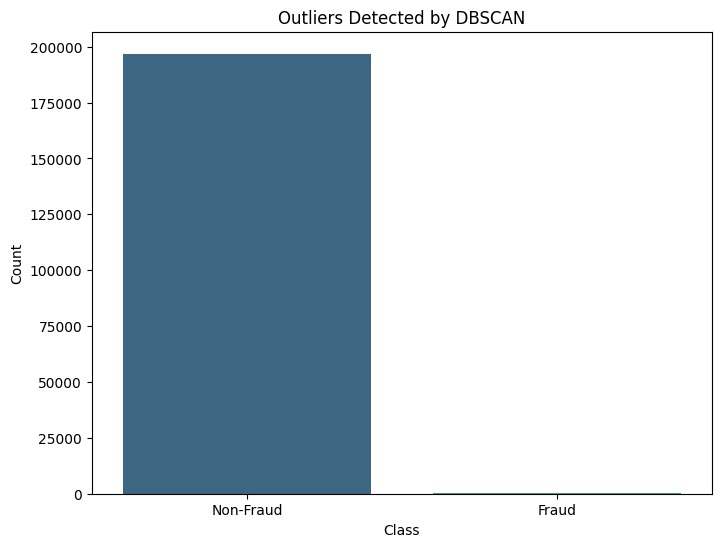

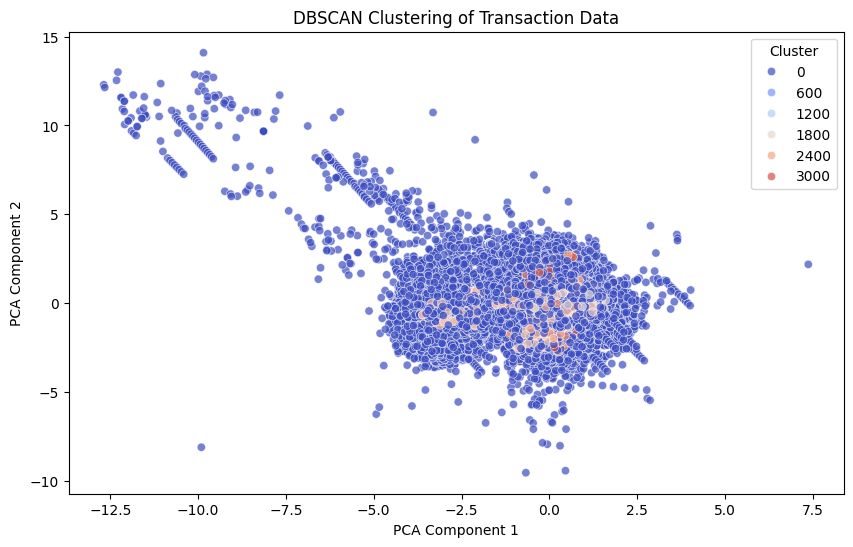

Number of outliers detected by DBSCAN: 197350


In [152]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Select features (V1 to V28) for clustering
features = [f'V{i}' for i in range(1, 29)]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_eda[features])

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust 'eps' and 'min_samples' as needed
df_eda['DBSCAN_Label'] = dbscan.fit_predict(X_scaled)

# DBSCAN labels: -1 indicates outliers (potential frauds), 0+ indicates different clusters
outliers = df_eda[df_eda['DBSCAN_Label'] == -1]
inliers = df_eda[df_eda['DBSCAN_Label'] != -1]

# Plot the number of outliers (potential frauds)
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=outliers, palette='viridis')
plt.title('Outliers Detected by DBSCAN')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

# Visualize the DBSCAN clusters (first two PCA components for simplicity)
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a scatter plot of DBSCAN results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_eda['DBSCAN_Label'], palette='coolwarm', alpha=0.7)
plt.title('DBSCAN Clustering of Transaction Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()

# Output the number of outliers
print(f"Number of outliers detected by DBSCAN: {len(outliers)}")

In [153]:
X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [154]:


scaler = StandardScaler()
X_train[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

In [155]:
from sklearn.neighbors import NearestNeighbors
import torch

# Choose number of neighbors (e.g., 10)
n_neighbors = 10
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(X_train)

# Find the nearest neighbors for each data point
distances, indices = knn.kneighbors(X_train)

# Create an edge list based on neighbors
edge_index = []
for i, neighbors in enumerate(indices):
    for neighbor in neighbors:
        if i != neighbor:  # Avoid self-loops
            edge_index.append([i, neighbor])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

In [156]:
!pip install torch_geometric

In [157]:
# Convert features and labels to tensors
x = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float)
y = torch.tensor(y_train.values, dtype=torch.long)

# Create the Data object
data = Data(x=x, edge_index=edge_index, y=y)

In [162]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.fc = torch.nn.Linear(out_channels, 2)  # Binary classification

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return self.fc(x)

In [164]:
# Initialize model, optimizer, and loss function
model = GraphSAGE(in_channels=x.size(1), hidden_channels=64, out_channels=2)
optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(50):  # Train for 50 epochs
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)  # Forward pass
    loss = criterion(out, data.y)        # Compute loss
    loss.backward()
    optimizer.step()                     # Update model weights

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.4075
Epoch 2, Loss: 0.3430
Epoch 3, Loss: 0.2805
Epoch 4, Loss: 0.2211
Epoch 5, Loss: 0.1686
Epoch 6, Loss: 0.1240
Epoch 7, Loss: 0.0879
Epoch 8, Loss: 0.0603
Epoch 9, Loss: 0.0405
Epoch 10, Loss: 0.0272
Epoch 11, Loss: 0.0187
Epoch 12, Loss: 0.0135
Epoch 13, Loss: 0.0103
Epoch 14, Loss: 0.0083
Epoch 15, Loss: 0.0070
Epoch 16, Loss: 0.0060
Epoch 17, Loss: 0.0054
Epoch 18, Loss: 0.0050
Epoch 19, Loss: 0.0047
Epoch 20, Loss: 0.0046
Epoch 21, Loss: 0.0046
Epoch 22, Loss: 0.0046
Epoch 23, Loss: 0.0046
Epoch 24, Loss: 0.0046
Epoch 25, Loss: 0.0047
Epoch 26, Loss: 0.0047
Epoch 27, Loss: 0.0047
Epoch 28, Loss: 0.0046
Epoch 29, Loss: 0.0046
Epoch 30, Loss: 0.0045
Epoch 31, Loss: 0.0045
Epoch 32, Loss: 0.0044
Epoch 33, Loss: 0.0043
Epoch 34, Loss: 0.0042
Epoch 35, Loss: 0.0042
Epoch 36, Loss: 0.0041
Epoch 37, Loss: 0.0041
Epoch 38, Loss: 0.0040
Epoch 39, Loss: 0.0040
Epoch 40, Loss: 0.0040
Epoch 41, Loss: 0.0040
Epoch 42, Loss: 0.0040
Epoch 43, Loss: 0.0040
Epoch 44, Loss: 0.00

In [165]:
from sklearn.metrics import precision_score, recall_score

model.eval()
with torch.no_grad():
    predictions = model(data.x, data.edge_index).argmax(dim=1)
    accuracy = (predictions == data.y).sum().item() / len(data.y)
    precision = precision_score(data.y.numpy(), predictions.numpy())
    recall = recall_score(data.y.numpy(), predictions.numpy())

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9993
Precision: 0.8338
Recall: 0.7612
